In [1]:
import shapely
import geopandas as gpd
import numpy as np
import pandas as pd
import pathlib
import rasterio
import cv2
import xarray as xr
import scipy

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches

from matplotlib.colors import LightSource

In [2]:
data_dir = pathlib.Path("~/data/vcl/dataset").expanduser()

In [3]:
extent_klein = gpd.read_file("C:/Users/hemert/data/vcl/dataset/afmetingen_krappebox.shp").to_crs(epsg=28992).iloc[0].geometry
extent_groot = gpd.read_file("C:/Users/hemert/data/vcl/dataset/afmetingen_box.shp").to_crs(epsg=28992).iloc[0].geometry
sat_img_file = pathlib.Path("C:/Users/hemert/data/vcl/dataset/test3.tif")
ds_b0_file = data_dir / "originele_bodem.tif"
ds_file = data_dir / "concentratie_data_gw_model.nc"

In [4]:
bodem = rasterio.open(ds_b0_file).read(1)
bodem[np.where(bodem == -9999)] = -43.8

# Open top view of Terschelling an transpose to (H, W, C)
sat = rasterio.open(sat_img_file).read()
sat = np.transpose(sat, (1, 2, 0))

plt_extent = rasterio.open(ds_b0_file).bounds
plt_extent_b = (plt_extent[0], plt_extent[2], plt_extent[1], plt_extent[3])

ds = xr.open_dataset(ds_file)

In [5]:
bounds = shapely.bounds(extent_klein)
minx = bounds[0]
miny = bounds[1]
maxx = bounds[2]
maxy = bounds[3]

plt_extent = rasterio.open(sat_img_file).bounds
plt_extent = (plt_extent[0], plt_extent[2], plt_extent[1], plt_extent[3])

mid_point_klein = extent_klein.centroid.coords[0]

In [6]:
sat_bounds = rasterio.open(sat_img_file).bounds
bodem_bounds = rasterio.open(ds_b0_file).bounds
left = max([sat_bounds[0], bodem_bounds[0]])
bottom = max([sat_bounds[1], bodem_bounds[1]])
right = min([sat_bounds[2], bodem_bounds[2]])
top = min([sat_bounds[3], bodem_bounds[3]])

t_bodem = rasterio.open(ds_b0_file).transform
t_sat = rasterio.open(sat_img_file).transform

plt_extent = (left, right, bottom, top)
plt_extent_c = (ds.x.values.min(), ds.x.values.max(), ds.y.values.min(), ds.y.values.max())

In [7]:
window_bodem_min = ~t_bodem * (left, top)
window_bodem_max = ~t_bodem * (right, bottom)

window_sat_min = ~t_sat * (left, top)
window_sat_max = ~t_sat * (right, bottom)

In [8]:
bodem = bodem[int(window_bodem_min[1]):int(window_bodem_max[1]),
             int(window_bodem_min[0]):int(window_bodem_max[0])]
sat = sat[int(window_sat_min[1]):int(window_sat_max[1]),
         int(window_sat_min[0]):int(window_sat_max[0])]

In [9]:
sat_scaled = cv2.resize(sat, dsize=(bodem.shape[1], bodem.shape[0]), interpolation=cv2.INTER_CUBIC).astype('float64') / 255

ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.hillshade(bodem, vert_exag=5, dx=20, dy=20)
sat_shade = ls.shade_rgb(sat_scaled[..., :3], bodem, vert_exag=2, blend_mode='soft')

In [10]:
coords_klein = list(extent_klein.exterior.coords)
coords_klein = pd.DataFrame(coords_klein)
coords_klein.columns = ['x', 'y']

xmin = coords_klein.idxmin(0)['x']
ymin = coords_klein.idxmin(0)['y']
xmax = coords_klein.idxmax(0)['x']
ymax = coords_klein.idxmax(0)['y']

In [11]:
# Find bottom left point and bottom right point of original extent
bottom_point_klein = [coords_klein.iloc[ymin]['x'], coords_klein.iloc[ymin]['y']]
right_point_klein = [coords_klein.iloc[xmax]['x'], coords_klein.iloc[xmax]['y']]

# Compute the rotation angle of original extent
o = right_point_klein[1] - bottom_point_klein[1]
a = right_point_klein[0] - bottom_point_klein[0]

angle_1 = np.rad2deg(np.arctan(o/a))

In [12]:
# Rotate original extent s.t. it has a 'straight' orientation
extent_klein_rotated = shapely.affinity.rotate(extent_klein, -angle_1)

In [156]:
X2, Y2 = np.meshgrid(
    np.linspace(xmin, xmax, rot_ds[:, 177:462, 113:683].shape[2]),
    np.linspace(ymax, ymin, rot_ds[:, 177:462, 113:683].shape[1])
)

[]

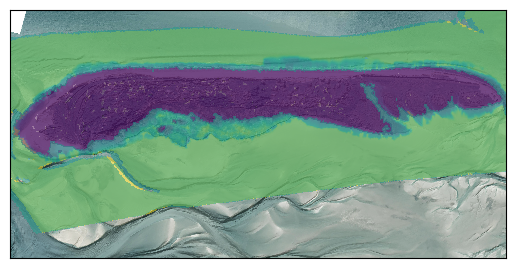

In [158]:
fig, ax = plt.subplots()
im = ax.imshow(sat_shade, interpolation='none',
                   extent=plt_extent, clip_on=True
                  )
im_b = ax.contourf(X2, Y2, rot_ds[-10, 177:462, 113:683], levels=[0, 1.5, 16], extent=plt_extent_c, alpha=0.5)
im_c = ax.imshow(ds.conc[-10, :, :], extent=plt_extent_c, clip_on=True, alpha=0.5)
# im_b = ax.imshow(bodem, interpolation='none',
#                  extent=plt_extent, clip_on=True, alpha=0.6)

# Rotate image (and clip, due to clip_on=True)
transform = mtransforms.Affine2D().rotate_deg_around(mid_point_klein[0], mid_point_klein[1], -angle_1)
trans_data = transform + ax.transData
im.set_transform(trans_data)
im_c.set_transform(trans_data)

# Set bounds to rotated extent bounds
xmin, ymin, xmax, ymax = extent_klein_rotated.exterior.bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

ax.set_xticks([])
ax.set_yticks([])

In [14]:
def rotate_and_crop(arr, ang):
    """Array arr to be rotated by ang degrees and cropped afterwards"""
    arr_rot = scipy.ndimage.rotate(arr, ang, reshape=True, order=0, cval=np.nan)

    shift_up = np.ceil(np.arcsin(abs(ang) / 360 * 2 * np.pi) * arr.shape[1])
    shift_right = np.ceil(np.arcsin(abs(ang) / 360 * 2 * np.pi) * arr.shape[0])

    arr_crop = arr_rot[
        int(shift_up) : arr_rot.shape[0] - int(shift_up),
        int(shift_right) : arr_rot.shape[1] - int(shift_right),
    ]
    return arr_rot

In [15]:
dummy = rotate_and_crop(ds.conc.values[0, :, :], -angle_1)

rot_ds = np.zeros((ds.conc.shape[0], dummy.shape[0], dummy.shape[1]))
for i in range(rot_ds.shape[0]):
    rot_ds[i, :, :] = rotate_and_crop(ds.conc.values[i, :, :], -angle_1)

(592989.1664214581, 607196.0962681334)

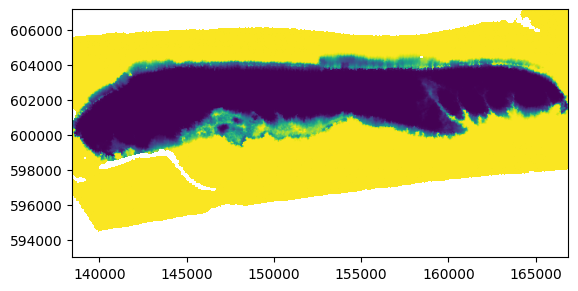

In [98]:
fig, ax = plt.subplots()
xmin1, ymin1, xmax1, ymax1 = geom_rot.bounds
ax.imshow(rot_ds[-10, ...], extent=(xmin1, xmax1, ymin1, ymax1))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [17]:
left = ds.conc.x.values[0]
bottom = ds.conc.y.values[-1]
right = ds.conc.x.values[-1]
top = ds.conc.y.values[0]

In [18]:
geom = shapely.Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])

In [27]:
xmax1

172320.77000928237

In [20]:
geom_rot = shapely.affinity.rotate(geom, -angle_1)
gdf =  gpd.GeoDataFrame(geometry=[geom_rot])

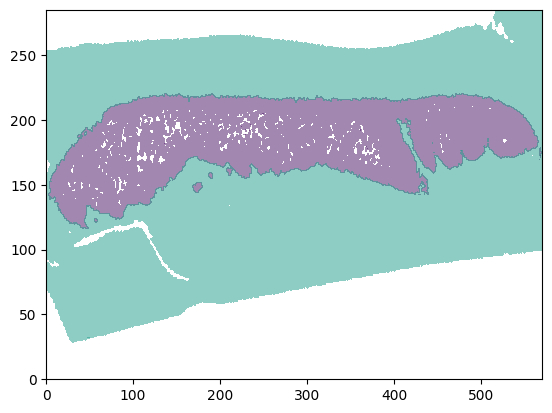

In [155]:
fig, ax = plt.subplots()
xmin1, ymin1, xmax1, ymax1 = geom_rot.bounds
# ax.imshow(rot_ds[-10, ...], extent=(xmin1, xmax1, ymin1, ymax1))
# ax.imshow(rot_ds[-10, 177:462, 113:683], extent=(xmin, xmax, ymin, ymax))
im_c = ax.contourf(X2, Y2, rot_ds[-10, 177:462, 113:683], levels=[0, 1.5, 16], extent=plt_extent_c, alpha=0.5)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# gdf.plot(ax=ax, alpha=0.5)

In [23]:
gpd.read_file("C:/Users/hemert/data/vcl/dataset/afmetingen_krappebox.shp").to_crs(epsg=28992).iloc[0].geometry.exterior.bounds

(137089.23739328573, 589482.387710005, 168249.95205781085, 610702.874979586)

In [24]:
ds.conc.z.values
zmin = ds.conc.z.values[-1]
zmax = ds.conc.z.values[0]

(592989.1664214581, 607196.0962681334)

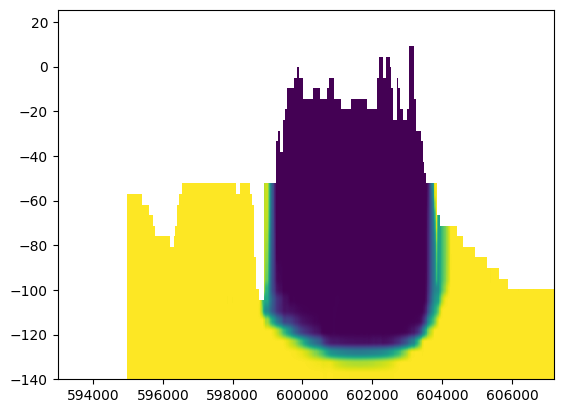

In [141]:
fig, ax = plt.subplots()
xmin1, ymin1, xmax1, ymax1 = geom_rot.bounds
ax.imshow(rot_ds[:, 177:462, 200], extent=(ymax, ymin, zmin, zmax), aspect="auto")
ax.set_xlim(ymin, ymax)
# ax.set_ylim(ymin, ymax)

In [36]:
coords = list(geom_rot.exterior.coords)
max_x = coords[0]
max_y = coords[0]
min_x = coords[0]
min_y = coords[0]
for coord in coords:
    if coord[0] > max_x[0]:
        max_x = coord
    if coord[0] < min_x[0]:
        min_x = coord
    if coord[1] > max_y[1]:
        max_y = coord
    if coord[1] < min_y[1]:
        min_y = coord

In [38]:
print(min_x)
print(max_x)
print(min_y)
print(max_y)

(132779.22999071763, 596170.2613537818)
(172320.77000928237, 606679.7386462184)
(166868.657180652, 586814.3298735835)
(138231.342819348, 616035.6701264167)


In [65]:
xjes = rot_ds.shape[2]
yjes = rot_ds.shape[1]

In [66]:
x_dif = (min_y[0] - max_y[0]) / xjes
y_dif = (max_x[1] - min_x[1]) / yjes

In [76]:
(xmin - max_y[0]) / x_dif

6.39749484997951

In [78]:
abs(ymin - min_x[1]) / y_dif

177.37529455277706

In [67]:
y_dif

17.934261591188807

In [111]:
dx = (xmax1 - xmin1) / xjes
dy = (ymax1 - ymin1) / yjes

In [114]:
print((xmin - xmin1) / dx)
xjes - (xmax1 - xmax) / dx

113.83675065021728


682.9541109393795

In [131]:
print(yjes - (ymin - ymin1) / dy)
(ymax1 - ymax) / dy

462.17083317375597


177.26737501206173

C:\Users\hemert\AppData\Local\Temp\ipykernel_32\3731557860.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(Y, Z, rot_ds[:, 177:462, 200], levels=levels, extent=(ymax, ymin, zmin, zmax), aspect="auto")


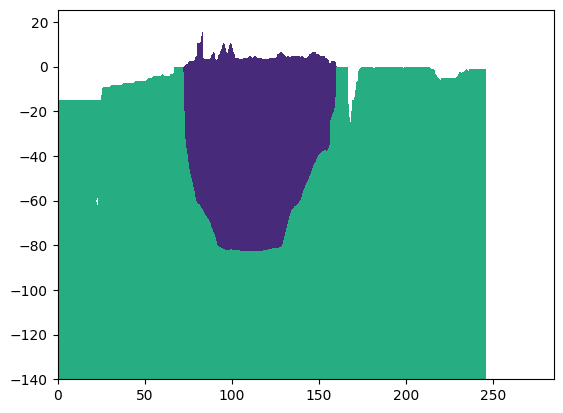

In [144]:
Y, Z = np.meshgrid(
    np.linspace(0, rot_ds[:, 177:462, :].shape[1], rot_ds[:, 177:462, :].shape[1]), ds.z
)
levels=[-3, 1.5, 16]
plt.contourf(Y, Z, rot_ds[:, 177:462, 200], levels=levels, extent=(ymax, ymin, zmin, zmax), aspect="auto")

In [ ]:
ax.imshow(rot_ds[:, 177:462, 114], extent=(ymax, ymin, zmin, zmax), aspect="auto")